<a href="https://colab.research.google.com/github/chaitanyakiran/Future-of-DRUG-Design-with-ReinforcementLearning/blob/main/Python_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome

In [1]:
# -*- coding: utf-8 -*-
"""Molecule_Protein.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1xV32BbH8poCWTn2N_Dbc248xP73odAP7
"""

!pip install rdkit Chem

!pip install torch torch_geometric

!pip install DataLoader

!pip install Data

# import packages

# general tools
import numpy as np

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch.nn as nn
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv

class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels=16, out_channels=32)
        self.conv2 = GCNConv(in_channels=32, out_channels=64)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
gnn_model = GNNModel()

# Example using PyTorch
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Assume 'data' is a graph data object containing features and edge_index
gnn_model.train()
optimizer.zero_grad()
output = gnn_model(data)  # Forward pass
loss = criterion(output, data.y)  # Compute loss
loss.backward()  # Backpropagate
optimizer.step()  # Update weights

"""**Atom Featurization**"""

def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

def get_atom_features(atom,
                      use_chirality = True,
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms - 43

    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

    # compute atom features

    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])  #5

    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"]) #7

    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

    is_in_a_ring_enc = [int(atom.IsInRing())]

    is_aromatic_enc = [int(atom.GetIsAromatic())]

    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc

    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

"""**Bond Featurization**"""

def get_bond_features(bond,
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

    bond_is_conj_enc = [int(bond.GetIsConjugated())]

    bond_is_in_ring_enc = [int(bond.IsInRing())]

    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

"""**Generating labeled Pytorch Geometric Graph Objects**"""

def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:

    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)

    Outputs:

    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning

    """
    x_smiles=['CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(C)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)\C=C\CF)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(c12)C(F)(F)F',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C(F)=C)c1cccc2cccc(Cl)c12',
'C[C@@H]1CN2[C@H](CN1C(=O)C=C)C(=O)N(C)c1cnc3c(F)c(c(Cl)cc3c21)-c1c(O)cccc1F',
'CCc1cccc2cccc(N3CCc4c(C3)nc(OC[C@@H]3CCCN3C)nc4N3CCN([C@@H](CC#N)C3)C(=O)C=C)c12',
'CC(C)c1ccccc1-n1c2cc(c(Cl)cc2c(nc1=O)N1CCN(CC1)C(=O)C=C)-c1c(C)ccc2[nH]ncc12',
'COC\C=C\C(=O)N1CCN(C[C@@H]1CC#N)c1nc(OC[C@@H]2CCCN2C)nc2CN(CCc12)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2ccccc12']
    y=[1,1,1,1,1,1,1,1,1,1]
    data_list = []

    for (smiles, y_val) in zip(x_smiles, y):

        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)

        X = torch.tensor(X, dtype = torch.float)

        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)

        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))

        for (k, (i,j)) in enumerate(zip(rows, cols)):

            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

        EF = torch.tensor(EF, dtype = torch.float)

        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)

        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

"""**Training Loop and Summary(GNNs)**"""

# canonical training loop for a Pytorch Geometric GNN model gnn_model
x_smiles=['CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(C)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)\C=C\CF)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(c12)C(F)(F)F',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C(F)=C)c1cccc2cccc(Cl)c12',
'C[C@@H]1CN2[C@H](CN1C(=O)C=C)C(=O)N(C)c1cnc3c(F)c(c(Cl)cc3c21)-c1c(O)cccc1F',
'CCc1cccc2cccc(N3CCc4c(C3)nc(OC[C@@H]3CCCN3C)nc4N3CCN([C@@H](CC#N)C3)C(=O)C=C)c12',
'CC(C)c1ccccc1-n1c2cc(c(Cl)cc2c(nc1=O)N1CCN(CC1)C(=O)C=C)-c1c(C)ccc2[nH]ncc12',
'COC\C=C\C(=O)N1CCN(C[C@@H]1CC#N)c1nc(OC[C@@H]2CCCN2C)nc2CN(CCc12)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2ccccc12']
y=[1,1,1,1,1,1,1,1,1,1]

# create list of molecular graph objects from list of SMILES x_smiles and list of labels y
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y)

# create dataloader for training
dataloader = DataLoader(dataset = data_list, batch_size = 2**7)

# define loss function
loss_function = nn.MSELoss()

# define optimiser
optimiser = torch.optim.Adam(gnn_model.parameters(), lr = 1e-3)

# loop over 10 training epochs
for epoch in range(10):

    # set model to training mode
    gnn_model.train()

    # loop over minibatches for training
    for (k, batch) in enumerate(dataloader):

        # compute current value of loss function via forward pass
        output = gnn_model(batch)
        loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))

        # set past gradient to zero
        optimiser.zero_grad()

        # compute current gradient via backward pass
        loss_function_value.backward()

        # update model weights using gradient and optimisation method
        optimiser.step()



!pip install rdkit

!pyenv("Version","C:\Users...\python.exe");

"""How to neglect/eliminate the hydrogen bonds from this code?"""

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D, rdDepictor, IPythonConsole
rdDepictor.SetPreferCoordGen(True)
from IPython.display import Image

# smiles = data["smiles"][5:6].values
smiles = ['CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(C)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)\C=C\CF)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(c12)C(F)(F)F',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C(F)=C)c1cccc2cccc(Cl)c12',
'C[C@@H]1CN2[C@H](CN1C(=O)C=C)C(=O)N(C)c1cnc3c(F)c(c(Cl)cc3c21)-c1c(O)cccc1F',
'CCc1cccc2cccc(N3CCc4c(C3)nc(OC[C@@H]3CCCN3C)nc4N3CCN([C@@H](CC#N)C3)C(=O)C=C)c12',
'CC(C)c1ccccc1-n1c2cc(c(Cl)cc2c(nc1=O)N1CCN(CC1)C(=O)C=C)-c1c(C)ccc2[nH]ncc12',
'COC\C=C\C(=O)N1CCN(C[C@@H]1CC#N)c1nc(OC[C@@H]2CCCN2C)nc2CN(CCc12)c1cccc2cccc(Cl)c12',
'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2ccccc12'] #['CN1C=NC2=C1C(=O)N(C(=O)N2C)C']

# 3D for lengths
mol3d = Chem.AddHs(Chem.MolFromSmiles(smiles[0]))
Chem.EmbedMolecule(mol3d, randomSeed=42)
Chem.MMFFOptimizeMolecule(mol3d)

bonds = [(x.GetBeginAtomIdx(), x.GetEndAtomIdx()) for x in mol3d.GetBonds()]

conf = mol3d.GetConformer()

b_lengths = []
b_angles = []

for b in bonds:
    bl = rdMolTransforms.GetBondLength(conf,b[0],b[1]) #GetAngleDeg
    b_lengths.append(str(round(bl,2)))


print(len(b_lengths))
print(b_lengths)
print(len(bonds))
print(bonds)

mol3d_without_Hs = Chem.RemoveHs(mol3d)

bonds = [(x.GetBeginAtomIdx(), x.GetEndAtomIdx()) for x in mol3d_without_Hs.GetBonds()]

conf = mol3d_without_Hs.GetConformer()

b_lengths = []
b_angles = []

for b in bonds:
    bl = rdMolTransforms.GetBondLength(conf,b[0],b[1]) #GetAngleDeg
    b_lengths.append(str(round(bl,2)))

for bnd in mol3d_without_Hs.GetBonds():
    bl = rdMolTransforms.GetBondLength(conf,bnd.GetBeginAtomIdx(),bnd.GetEndAtomIdx())
    # set the bond note on the molecule, which we'll draw:
    mol3d_without_Hs.GetBondWithIdx(bnd.GetIdx()).SetProp('bondNote',f'{bl:.2f}')

"""Chemistry-Convert-SMILES_to_Molecular_Graph"""

!git clone https://github.com/mathworks/Chemistry-Convert-SMILES_to_Molecular_Graph.git

# Commented out IPython magic to ensure Python compatibility.
# %cd Chemistry-Convert-SMILES_to_Molecular_Graph/
# %ls

!python ChemMolFromSmiles.py

!python echo_env.py

!python GetNodeFeaturesMatrix.py

!python GetNumAtoms.py

!python GetSubstructMatch.py

!python MolToPDBBlock.py



"""Reading, Drawing, and Analyzing a Molecule

Reading and drawing the molecule of caffeine
"""

import rdkit #RDKit ----------------------------------------------------------------
from rdkit import Chem
from rdkit.Chem import Draw

# define the smiles string and covert it into a molecule sturcture ------------
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

mol = Chem.MolFromSmiles(caffeine_smiles)

# draw the modecule -----------------------------------------------------------
Draw.MolToFile(mol, 'caffeine.png')

# draw the molecule with property ---------------------------------------------
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

Draw.MolToFile(mol, 'caffeine_with_prop.png')

import rdkit #RDKit ----------------------------------------------------------------
from rdkit import Chem
from rdkit.Chem import Draw

# define the smiles string and covert it into a molecule sturcture ------------
caffeine_smiles = 'CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2ccccc12'

mol = Chem.MolFromSmiles(caffeine_smiles)

# draw the modecule -----------------------------------------------------------
Draw.MolToFile(mol, 'caffeine1.png')

# draw the molecule with property ---------------------------------------------
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

Draw.MolToFile(mol, 'caffeine_with_prop1.png')

"""Displaying the atoms and bonds in the molecule of caffeine"""

import rdkit #RDKit ----------------------------------------------------------------
from rdkit import Chem

# define the smiles string and covert it into a molecule sturcture ------------
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

mol = Chem.MolFromSmiles(caffeine_smiles)

# print the atoms of the molecule ---------------------------------------------
for atom in mol.GetAtoms():
    print(atom.GetIdx(),',',
          atom.GetAtomicNum(),',',
          atom.GetIsAromatic(),',',
          atom.GetSymbol())

# print the bonds of the molecule ---------------------------------------------
for bond in mol.GetBonds():
    print(bond.GetBeginAtomIdx(),',',
          bond.GetEndAtomIdx(),',',
          bond.GetBondType())

"""Generating Molecular Fingerprint from a SMILES String"""

# import RDKit ----------------------------------------------------------------
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

# import numpy for data type conversion ---------------------------------------
import numpy as np

# define the smiles string and covert it into a molecule sturcture ------------
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

mol = Chem.MolFromSmiles(caffeine_smiles)

# retrieving RDK Fingerprint --------------------------------------------------
fingerprint_rdk = RDKFingerprint(mol)
print(">>> RDK Fingerprint = ", fingerprint_rdk)

fingerprint_rdk_np = np.array(fingerprint_rdk)
print(">>> RDK Fingerprint in numpy = ", fingerprint_rdk_np)
print(">>> RDK Fingerprint in numpy shape = ", fingerprint_rdk_np.shape)

print()

# retrieving Morgan Fingerprint -----------------------------------------------
fingerprint_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
print(">>> Morgan Fingerprint = ", fingerprint_morgan)

fingerprint_morgan_np = np.array(fingerprint_morgan)
print(">>> Morgan Fingerprint in numpy : ", fingerprint_morgan_np)
print(">>> Morgan Fingerprint in numpy shape = ", fingerprint_morgan_np.shape)

print()

"""Generating One-Hot Encoding from a SMILES string"""

# import library --------------------------------------------------------------
import numpy as np

# define SMILES characters ----------------------------------------------------
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']

# define encoder and decoder --------------------------------------------------
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )

def smiles_encoder( smiles, maxlen=120 ):
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X

def smiles_decoder( X ):
    smi = ''
    X = X.argmax( axis=-1 )
    for i in X:
        smi += index2smi[ i ]
    return smi

# get a taste of caffeine -----------------------------------------------------
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

caffeine_encoding = smiles_encoder(caffeine_smiles)

print(caffeine_encoding.shape) # (120, 56)

!pip install mol2vec

"""Generating Word Embedding from a SMILES String"""

# import rdkit/mol2vec/word2vec -----------------------------------------------
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

# import numpy/pandas ---------------------------------------------------------
import numpy as np
import pandas as pd

print(">>> read the data file ... ")
hiv = pd.read_csv('/content/bindingDB_ic50.csv')   #pd.read_csv('HIV.csv')
print(">>> data shape = ", hiv.shape)
print(">>> data columns = ", hiv.columns, "\n")
print(hiv)
print()

print(">>> create mol from smiles ... ")
hiv['mol'] = hiv['Ligand SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

print(">>> create sentence from mol ... ")
hiv['sentence'] = hiv.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], radius=1)), axis=1)

print(">>> load the word2vec model ... ")
w2v_model = word2vec.Word2Vec.load('model_300dim.pkl')

print(">>> create embedding from sentence ... ")
hiv['embedding'] = [DfVec(x) for x in sentences2vec(hiv['sentence'], w2v_model)]

print(">>> data columns = ", hiv.columns, "\n")

hiv_mol2vec = np.array([x.vec for x in hiv['embedding']])
hiv_mol2vec = pd.DataFrame(hiv_mol2vec)
print(">>> hiv_mol2vec shape = ", hiv_mol2vec.shape)
print(hiv_mol2vec)
print()

from rdkit.Chem import Draw
mols = hiv['Ligand SMILES'][:20]

#MolsToGridImage allows to paint a number of molecules at a time
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(hiv['Ligand SMILES'][:20].values))

"""Generating Molecular Representation in Graph"""



!pip install networkx

# import library --------------------------------------------------------------
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt

# define the smiles string and covert it into a molecule sturcture ------------
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
caffeine_mol = Chem.MolFromSmiles(caffeine_smiles)

# define the function for coverting rdkit object to networkx object -----------
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())

    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())

    return G

# conver rdkit object to networkx object --------------------------------------
caffeine_nx = mol_to_nx(caffeine_mol)

caffeine_atom = nx.get_node_attributes(caffeine_nx, 'atom_symbol')

color_map = {'C': 'cyan',
             'O': 'orange',
             'N': 'magenta'}

caffeine_colors = []
for idx in caffeine_nx.nodes():
    if (caffeine_nx.nodes[idx]['atom_symbol'] in color_map):
        caffeine_colors.append(color_map[caffeine_nx.nodes[idx]['atom_symbol']])
    else:
        caffeine_colors.append('gray')

nx.draw(caffeine_nx,
        labels=caffeine_atom,
        with_labels = True,
        node_color=caffeine_colors,
        node_size=800)

plt.show()

# print out the adjacency matrix ----------------------------------------------
matrix = np.asmatrix(nx.to_numpy_array(caffeine_nx))#nx.to_numpy_array(caffeine_nx)  #nx.to_numpy_matrix(caffeine_nx)
print(matrix)

!pip install --upgrade Graph2Vec

!pip install karateclub

"""Generating graph embedding for the molecules in the HIV/bindingDB dataset"""

#import rdkit/networkx/graph2vec ---------------------------------------------
from rdkit import Chem
import networkx as nx
#import Graph2Vec
from karateclub import Graph2Vec

# import numpy/pandas ---------------------------------------------------------
import numpy as np
import pandas as pd

print(">>> read the data file ... ")
hiv = pd.read_csv('/content/bindingDB_ic50.csv')    #pd.read_csv('HIV.csv')
print(">>> data shape = ", hiv.shape)
print(">>> data columns = ", hiv.columns, "\n")
print(hiv)
print()

print(">>> create mol from smiles ... ")
hiv['mol'] = hiv['Ligand SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

# define the function for coverting rdkit object to networkx object -----------
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())

    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())

    return G

print(">>> create nx from mol ... ")
hiv['graph'] = hiv['mol'].apply(lambda x: mol_to_nx(x))

print(">>> create graph embedding ... ")
model = Graph2Vec()
model.fit(hiv['graph'])
hiv_graph2vec = model.get_embedding()

hiv_graph2vec = pd.DataFrame(hiv_graph2vec)
print(">>> hiv_graph2vec shape = ", hiv_graph2vec.shape)
print(hiv_graph2vec)
print()



"""Conversion of Protein Sequence to Protein Graph

Loading in PDB files
"""

!pip install proteingraph

!pip install biopandas prody

import pandas as pd
from biopandas.pdb import PandasPdb
from prody import parsePDBHeader
from typing import Optional

def read_pdb_to_dataframe(
    pdb_path: Optional[str] = None,
    model_index: int = 1,
    parse_header: bool = True,
    ) -> pd.DataFrame:
    """
    Read a PDB file, and return a Pandas DataFrame containing the atomic coordinates and metadata.

    Args:
        pdb_path (str, optional): Path to a local PDB file to read. Defaults to None.
        model_index (int, optional): Index of the model to extract from the PDB file, in case
            it contains multiple models. Defaults to 1.
        parse_header (bool, optional): Whether to parse the PDB header and extract metadata.
            Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the atomic coordinates and metadata, with one row
            per atom
    """
    atomic_df = PandasPdb().read_pdb(pdb_path)
    if parse_header:
        header = parsePDBHeader(pdb_path)
    else:
        header = None
    atomic_df = atomic_df.get_model(model_index)
    if len(atomic_df.df["ATOM"]) == 0:
        raise ValueError(f"No model found for index: {model_index}")

    return pd.concat([atomic_df.df["ATOM"], atomic_df.df["HETATM"]]), header

df, df_header = read_pdb_to_dataframe('/content/3cdg.pdb')
df.head(10)

print(df.shape)

print(df_header.keys())

df.loc[df['atom_name']=='CA', ['x_coord', 'y_coord', 'z_coord']]

"""Simple 3D Visualizations — Plotting Atoms"""

!pip install plotly

import plotly.express as px

fig = px.scatter_3d(df, x='x_coord', y='y_coord', z='z_coord', color='element_symbol')
fig.update_traces(marker_size = 4)

fig.show()

"""**Manipulating PDB Dataframes — Building protein graphs**"""

!pip install graphein

"""We first process the dataframe using standard pandas methods. It is important to label each node (atom/residue) with a unique identifier."""

from graphein.protein.graphs import label_node_id

def process_dataframe(df: pd.DataFrame, granularity='CA') -> pd.DataFrame:
    """
    Process a DataFrame of protein structure data to reduce ambiguity and simplify analysis.

    This function performs the following steps:
    1. Handles alternate locations for an atom, defaulting to keep the first one if multiple exist.
    2. Assigns a unique node_id to each residue in the DataFrame, using a helper function label_node_id.
    3. Filters the DataFrame based on specified granularity (defaults to 'CA' for alpha carbon).

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing protein structure data to process. It is expected to contain columns 'alt_loc' and 'atom_name'.

    granularity : str, optional
        The level of detail or perspective at which the DataFrame should be analyzed. Defaults to 'CA' (alpha carbon).
    """
    # handle the case of alternative locations,
    # if so default to the 1st one = A
    if 'alt_loc' in df.columns:
      df['alt_loc'] = df['alt_loc'].replace('', 'A')
      df = df.loc[(df['alt_loc']=='A')]
    df = label_node_id(df, granularity)
    df = df.loc[(df['atom_name']==granularity)]
    return df

process_df = process_dataframe(df)
print(process_df.shape)

from graphein.protein.graphs import initialise_graph_with_metadata
g = initialise_graph_with_metadata(protein_df=process_df, # from above cell
                                    raw_pdb_df=df, # Store this for traceability
                                    pdb_code = '3cdg', #and again
                                    granularity = 'CA' # Store this so we know what kind of graph we have
                                    )

"""Add all the nodes to our graph"""

from graphein.protein.graphs import add_nodes_to_graph
g = add_nodes_to_graph(g)
print(g.nodes)

"""Add Peptide bond"""

import networkx as nx
def add_backbone_edges(G: nx.Graph) -> nx.Graph:
    # Iterate over every chain
    for chain_id in G.graph["chain_ids"]:
        # Find chain residues
        chain_residues = [
            (n, v) for n, v in G.nodes(data=True) if v["chain_id"] == chain_id
        ]
        # Iterate over every residue in chain
        for i, residue in enumerate(chain_residues):
            try:
                # Checks not at chain terminus
                if i == len(chain_residues) - 1:
                    continue
                # Asserts residues are on the same chain
                cond_1 = ( residue[1]["chain_id"] == chain_residues[i + 1][1]["chain_id"])
                # Asserts residue numbers are adjacent
                cond_2 = (abs(residue[1]["residue_number"] - chain_residues[i + 1][1]["residue_number"])== 1)

                # If this checks out, we add a peptide bond
                if (cond_1) and (cond_2):
                    # Adds "peptide bond" between current residue and the next
                    if G.has_edge(i, i + 1):
                        G.edges[i, i + 1]["kind"].add('backbone_bond')
                    else:
                        G.add_edge(residue[0],chain_residues[i + 1][0],kind={'backbone_bond'},)
            except IndexError as e:
                print(e)
    return G

g = add_backbone_edges(g)
print(len(g.edges()))

from graphein.protein.visualisation import plotly_protein_structure_graph

p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="3CDG Backbone Protein Graph",
    node_size_multiplier=1,
)
p.show()



"""Working with multi-chain PDB files 6KDE but i have used 4hx1"""

df, df_header = read_pdb_to_dataframe('/content/4hx1.pdb')
fig = px.scatter_3d(df, x='x_coord', y='y_coord', z='z_coord', color='chain_id')
fig.update_traces(marker_size = 4)

fig.show()

df = pd.concat((df[df['chain_id']=='A'], df[df['chain_id']=='B']))

df['chain_id'].unique()

"""Extracting protein interfaces using Pandas"""

import numpy as np

def get_contact_atoms(df1: pd.DataFrame, df2:pd.DataFrame = None , threshold:float = 7., coord_names=['x_coord', 'y_coord', 'z_coord']):
    # Extract coordinates from dataframes
    coords1 = df1[coord_names].to_numpy()
    coords2 = df2[coord_names].to_numpy()

    # Compute pairwise distances between atoms
    dist_matrix = np.sqrt(((coords1[:, None] - coords2) ** 2).sum(axis=2))

    # Create a new dataframe containing pairs of atoms whose distance is below the threshold
    pairs = np.argwhere(dist_matrix < threshold)
    atoms1, atoms2 = df1.iloc[pairs[:, 0]], df2.iloc[pairs[:, 1]]
    atoms1_id = atoms1['chain_id'].map(str) + ":" + atoms1['residue_name'].map(str) + ":" + atoms1['residue_number'].map(str)
    atoms2_id = atoms2['chain_id'].map(str) + ":" + atoms2['residue_name'].map(str) + ":" + atoms2['residue_number'].map(str)
    node_pairs = np.vstack((atoms1_id.values, atoms2_id.values)).T
    result = pd.concat([df1.iloc[np.unique(pairs[:, 0])], df2.iloc[np.unique(pairs[:, 1])]])

    return result, node_pairs

"""In this example we will get all atoms between chains A and B that are 7 Angstrom appart:"""

df_A = df[df['chain_id']=='A']
df_B = df[df['chain_id']=='B']
contact_atoms, node_pairs = get_contact_atoms(df_A, df_B, 7.)

import plotly.express as px
import plotly.graph_objects as go

# Create 3D scatter plots for df_A, df_B, and contact_atoms
fig = go.Figure()

# Add trace for df_A
fig.add_trace(
    go.Scatter3d(
        name='Chain A',
        x=df_A['x_coord'],
        y=df_A['y_coord'],
        z=df_A['z_coord'],
        mode='markers',
        marker=dict(size=4, color='blue', opacity=0.5),  # Adjust opacity here
    )
)

# Add trace for df_B
fig.add_trace(
    go.Scatter3d(
        name='Chain B',
        x=df_B['x_coord'],
        y=df_B['y_coord'],
        z=df_B['z_coord'],
        mode='markers',
        marker=dict(size=4, color='red', opacity=0.5),  # Adjust opacity here
    )
)

# Add trace for contact_atoms
fig.add_trace(
    go.Scatter3d(
        name='Contact Atoms',
        x=contact_atoms['x_coord'],
        y=contact_atoms['y_coord'],
        z=contact_atoms['z_coord'],
        mode='markers',
        marker=dict(size=6, color='orange'),  # You can adjust the color and opacity here
    )
)

# Customize the layout
fig.update_layout(
    scene=dict(
        aspectmode="cube",  # To maintain equal axis scaling
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)

# Show the plot
fig.show()



!pip install data

!pip install dset

!pip install tool

import os
import pickle
import time

import numpy as np
import pandas as pd
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from data.dset_tool import load_raw_dset
from models.df_ppi_model_new_fusion_layer import df_ppi_with_fusion_layer
from protein_descriptors.extracted_handcrafted_features.read_mat_file import read_mat_to_feat
from protein_embedding.prepare import prot_to_token
from utils.read_mat_file import loadmat_TEST_feat, loadmat_TEST_seq


def get_avelen(inds, dset):
    pos_A, pos_B, neg_A, neg_B = dset['seq_pairs']
    pos_AB = np.hstack((pos_A, pos_B))
    neg_AB = np.hstack((neg_A, neg_B))
    prots = np.concatenate((pos_AB, neg_AB), axis=0)
    prots = prots.flatten()
    prots = prots[inds]
    prots = np.unique(prots)
    do_dai = [len(seq) for seq in prots]
    avelen = int(sum(do_dai) / len(do_dai))
    return avelen


def load_new_feature(path_to_dir, name_APAACplus_):
    def ghep_cap(uni_, pair_):
        return uni_.loc[pair_.proteinA], uni_.loc[pair_.proteinB]

    def load_positive():
        POS_ = pd.read_csv('/content/pairs_pos.csv')
        print(POS_)

        f1_A, f1_B = ghep_cap(Fvector, POS_)
        f2_A, f2_B = ghep_cap(LD, POS_)
        f3_A, f3_B = ghep_cap(APAACplus, POS_)
        pos_A_ = np.concatenate([f1_A, f3_A, f2_A], axis=1)
        pos_B_ = np.concatenate([f1_B, f3_B, f2_B], axis=1)

        return pos_A_, pos_B_

    def load_negative():
        NEG_ = pd.read_csv('/content/pairs_neg.csv')
        print(NEG_)

        f1_A, f1_B = ghep_cap(Fvector, NEG_)
        f2_A, f2_B = ghep_cap(LD, NEG_)
        f3_A, f3_B = ghep_cap(APAACplus, NEG_)
        neg_A_ = np.concatenate([f1_A, f3_A, f2_A], axis=1)
        neg_B_ = np.concatenate([f1_B, f3_B, f2_B], axis=1)

        return neg_A_, neg_B_

    Fvector = read_mat_to_feat(path_to_dir + '/uni_Fvector_new.mat')
    print(Fvector)

    LD = read_mat_to_feat(path_to_dir + '/uni_LD.mat')
    print(LD)

    APAACplus = read_mat_to_feat(path_to_dir + '/' + name_APAACplus_ + '.mat')
    print(APAACplus)

    # print("\n", path_to_dir + '/' + name_APAACplus + '.mat')

    pos_feat_A, pos_feat_B = load_positive()
    neg_feat_A, neg_feat_B = load_negative()

    return pos_feat_A, pos_feat_B, neg_feat_A, neg_feat_B, pos_feat_A.shape[1]


def prepare_YEAST_token_and_handfeat_new(vocal, W1, fixlen_, dset, name_APAACplus_):
    # ----------------------------------------------------------------
    # Load hancrafted features
    # ----------------------------------------------------------------
    p = r"protein_descriptors/extracted_handcrafted_features/Yeastcore/apaacplus"
    pos_hand_A, pos_hand_B, neg_hand_A, neg_hand_B, handfeat_dim = load_new_feature(p, name_APAACplus_)

    hand_A = np.vstack([pos_hand_A, neg_hand_A])
    hand_B = np.vstack([pos_hand_B, neg_hand_B])

    # ----------------------------------------------------------------
    # Load embedding features
    # ----------------------------------------------------------------
    pos_seq_A, pos_seq_B, neg_seq_A, neg_seq_B = dset['seq_pairs']
    seqs_A = np.concatenate([pos_seq_A, neg_seq_A], axis=0)
    seqs_B = np.concatenate([pos_seq_B, neg_seq_B], axis=0)

    tokens_A = prot_to_token(vocal, seqs_A, fixlen_)
    tokens_B = prot_to_token(vocal, seqs_B, fixlen_)

    # print('tokens_A', tokens_A.shape)

    return tokens_A, hand_A, tokens_B, hand_B, handfeat_dim


def train_all_YEAST(featute_set: tuple, true_label, name_model, name_APAACplus_):
    start_time = time.time()
    tokens_A, hand_A, tokens_B, hand_B, handdim = prepare_YEAST_token_and_handfeat_new(trained_W1['vocabulary'],
                                                                                       trained_W1[
                                                                                           'embedding_matrix'],
                                                                                       protlen,
                                                                                       yeast_dset, name_APAACplus_)
    print(hand_A.shape)

    # --------------------------------------------------------------
    # Shuffle data
    # --------------------------------------------------------------
    np.random.seed(123456)
    indx = np.arange(len(true_label))
    np.random.shuffle(indx)
    tokens_A, hand_A, tokens_B, hand_B = tokens_A[indx], hand_A[indx], tokens_B[indx], hand_B[indx]
    true_label = true_label[indx]

    true_label = to_categorical(true_label)
    opt = Adam(learning_rate=0.001, decay=0.001)

    model_out = df_ppi_with_fusion_layer(protlen, handdim, W1=trained_W1['embedding_matrix'], n_units=1024)

    model_out.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Train model
    model_out.fit([tokens_A, hand_A, tokens_B, hand_B], true_label,
                  batch_size=100,
                  epochs=64,
                  shuffle=False,
                  verbose=0)

    print("Training time: ", time.time() - start_time)

    # -------------------------------------------------------------------------
    # SAVE
    # -------------------------------------------------------------------------
    try:
        model_out.save(name_model)
    except:
        new_dir = input("SAVE ERROR, ENTER new folder to save:")
        os.mkdir(new_dir)
        model_out.save(name_model)

    return model_out


def load_Xy_test(path_to_dir, testset_name):
    Fvector_A, Fvector_B = loadmat_TEST_feat(path_to_dir + '/feat_' + testset_name + '_Fvector_new.mat')
    LD_A, LD_B = loadmat_TEST_feat(path_to_dir + '/feat_' + testset_name + '_LD.mat')
    APAACplus_A, APAACplus_B = loadmat_TEST_feat(path_to_dir + '/feat_' + testset_name + '_APAACPlus_lg30.mat')

    feat_A = np.concatenate([Fvector_A, LD_A, APAACplus_A], axis=1)
    feat_B = np.concatenate([Fvector_B, LD_B, APAACplus_B], axis=1)

    print(feat_B.shape)
    true_label = np.array([1] * len(feat_B))

    return feat_A, feat_B, true_label


def run_test(testset_name):
    path_to_dir = "protein_descriptors/extracted_handcrafted_features/extracted_TEST"
    X_test_A, X_test_B, y_test = load_Xy_test(path_to_dir, testset_name)

    test_seq_A, test_seq_B = loadmat_TEST_seq('data/Testsets/' + testset_name + '.mat')

    tokens_A = prot_to_token(trained_W1['vocabulary'], test_seq_A, protlen)
    tokens_B = prot_to_token(trained_W1['vocabulary'], test_seq_B, protlen)

    y_prob = trained_model.predict([tokens_A, X_test_A, tokens_B, X_test_B])

    # ----------------------------------------------------------
    # SAVE
    # ----------------------------------------------------------
    pickle.dump(y_prob, open("results/independent_TEST_full_yeastcore_run9/y_prob_on_" + testset_name + ".pkl", "wb"))

    y_pred = np.argmax(y_prob, axis=1)
    ACC = round(np.sum(y_pred == y_test) / len(y_test), 4)
    print(testset_name, '> Accuracy {}'.format(ACC), np.sum(y_pred == y_test), len(y_test))

    # return A, B, handfeat_dim


if __name__ == "__main__":
    trained_W1 = pickle.load(open("protein_embedding/doc2vec/d2v_1gram_32dim.pkl", "rb"))
    trained_W1['vocabulary']['<unk>'] = len(trained_W1['vocabulary'])
    trained_W1['embedding_matrix'] = np.concatenate([trained_W1['embedding_matrix'],
                                                     np.zeros((1, trained_W1['embedding_matrix'].shape[1]))], axis=0)

    print("Embedding", trained_W1['embedding_matrix'].shape)
    print("Vocabulary", len(trained_W1['vocabulary']))

    yeast_dset, summary = load_raw_dset("data/Yeastcore")
    id_pairs = yeast_dset['id_pairs']
    labels = yeast_dset['labels']
    print("Summary:", summary)
    print("Number of pairs:", len(id_pairs))

    protlen = get_avelen(np.arange(len(id_pairs)), yeast_dset)
    print("Fixed length protein", protlen)

    savedir = "trained_Yeastcore_d2v_1gram_32dim_run9.h5"

    if not os.path.exists(savedir):
        lg = 30
        name_APAACplus = 'uni_APAACPlus_lg' + str(lg)
        trained_model = train_all_YEAST(id_pairs, labels, savedir, name_APAACplus)
    else:
        trained_model = load_model(savedir)

    # ---------------------------------------------------
    # Test on Cross-species
    # ---------------------------------------------------
    run_test("Celeg")
    run_test("Ecoli")
    run_test("Hpylo")
    run_test("Hsapi")
    run_test("Mmusc")

    # ---------------------------------------------------
    # Test on PPI network
    # ---------------------------------------------------
    run_test("Onecore")
    run_test("Wnt")
    run_test("Cancer")



import json
import os
import os.path as osp
from itertools import product
from typing import Callable, List, Optional

import numpy as np
import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.utils import remove_self_loops


class PPI(InMemoryDataset):
    r"""The protein-protein interaction networks from the `"Predicting
    Multicellular Function through Multi-layer Tissue Networks"
    <https://arxiv.org/abs/1707.04638>`_ paper, containing positional gene
    sets, motif gene sets and immunological signatures as features (50 in
    total) and gene ontology sets as labels (121 in total).

    Args:
        root (str): Root directory where the dataset should be saved.
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"test"`, loads the test dataset. (default: :obj:`"train"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #tasks
        * - 20
          - ~2,245.3
          - ~61,318.4
          - 50
          - 121
    """

    url = '/content/diamond_ppi.txt' #'https://data.dgl.ai/dataset/ppi.zip'

    def __init__(
        self,
        root: str,
        split: str = 'train',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:

        assert split in ['train', 'val', 'test']

        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            self.load(self.processed_paths[0])
        elif split == 'val':
            self.load(self.processed_paths[1])
        elif split == 'test':
            self.load(self.processed_paths[2])

    @property
    def raw_file_names(self) -> List[str]:
        splits = ['train', 'valid', 'test']
        files = ['feats.npy', 'graph_id.npy', 'graph.json', 'labels.npy']
        return [f'{split}_{name}' for split, name in product(splits, files)]

    @property
    def processed_file_names(self) -> List[str]:
        return ['train.pt', 'val.pt', 'test.pt']

    def download(self) -> None:
        path = download_url(self.url, self.root)
        extract_zip(path, self.raw_dir)
        os.unlink(path)

    def process(self) -> None:
        import networkx as nx
        from networkx.readwrite import json_graph

        for s, split in enumerate(['train', 'valid', 'test']):
            path = osp.join(self.raw_dir, f'{split}_graph.json')
            with open(path, 'r') as f:
                G = nx.DiGraph(json_graph.node_link_graph(json.load(f)))

            x = np.load(osp.join(self.raw_dir, f'{split}_feats.npy'))
            x = torch.from_numpy(x).to(torch.float)

            y = np.load(osp.join(self.raw_dir, f'{split}_labels.npy'))
            y = torch.from_numpy(y).to(torch.float)

            data_list = []
            path = osp.join(self.raw_dir, f'{split}_graph_id.npy')
            idx = torch.from_numpy(np.load(path)).to(torch.long)
            idx = idx - idx.min()

            for i in range(int(idx.max()) + 1):
                mask = idx == i

                G_s = G.subgraph(
                    mask.nonzero(as_tuple=False).view(-1).tolist())
                edge_index = torch.tensor(list(G_s.edges)).t().contiguous()
                edge_index = edge_index - edge_index.min()
                edge_index, _ = remove_self_loops(edge_index)

                data = Data(edge_index=edge_index, x=x[mask], y=y[mask])

                if self.pre_filter is not None and not self.pre_filter(data):
                    continue

                if self.pre_transform is not None:
                    data = self.pre_transform(data)

                data_list.append(data)
            self.save(data_list, self.processed_paths[s])

"""**SGPPI: structure-aware prediction of protein-protein interactions in rigorous conditions with graph convolutional network**"""

!git clone https://github.com/emersON106/SGPPI.git

# Commented out IPython magic to ensure Python compatibility.
# %cd SGPPI
# %ls

!pip install dgl

!pip install torch==1.5.0

!pip install scipy==1.5.2

!pip install scikit-learn==0.24.2

!pip install dgl==0.7.2

!pip install numpy==1.19.1

!python feature_extract.py -i Q96B49 -o protein_features.txt





"""**Building a Solubility Molecule Prediction Model using Graph Neural Networks**"""

!pip install pysmiles

!pip install torch-geometric

import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)  # Anything higher than warning

df = pd.read_csv('/content/bindingDB_ic50.csv') #read dataset (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
X_smiles = list(df['Ligand SMILES']) #get smiles strings from file
#Y = np.asarray(df['Solubility']) #get solubility values from file
Y = np.asarray(df['IC50 (nM)']) #get solubility values from file
elements = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',    #list of all elements in the dataset
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al',
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C']

#convert element to a one-hot vector of dimension len(elements)
def element_to_onehot(element):
    out = []
    for i in range(0, len(element)):
        v = np.zeros(len(elements))
        v[elements.index(element[i])] = 1.0
        out.append(v)
    return np.asarray(out)

#convert solubility value to one-hot class vector
def val_to_class(val):
    if val < -3.65: #insoluble
        return [1, 0, 0]
    elif val < -1.69: #slightly soluble
        return [0, 1, 0]
    else: #soluble
        return [0, 0, 1]

#process SMILES strings into graphs
nodes = []
edge_index = []
for smiles in tqdm(X_smiles):
    try:
        G = read_smiles(smiles, explicit_hydrogen=True)
        feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1])
        edges = np.asarray(G.edges)
        index = np.asarray([edges[:,0], edges[:,1]]) #reshape indices into shape [2, -1]
        nodes.append(feature)
        edge_index.append(index)
        #print("Nodes of SMILES String",nodes)
        #print("Edges:",edge_index)
    except:
        pass

#Generate Data objects
data = list()

#process graphs into torch_geometric Data objects
for i in tqdm(range(0, len(nodes))):
    x = torch.tensor(nodes[i], dtype=torch.float) #convert node features into torch tensor
    edges = torch.tensor(edge_index[i], dtype=torch.long) #convert edge index into torch tensor
    y = torch.tensor([val_to_class(Y[i])], dtype=torch.float) #change shape of label and convert to tensor
    data.append(Data(x=x,edge_index=edges, y=y)) #add the Data object to the list of data
random.shuffle(data)
train = data[:int(len(data)*0.8)] #train set
test = data[int(len(data)*0.8):] #val set
train = data

#define the message passing network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(61, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 32)
        self.conv4 = GCNConv(32, 32)
        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 3)

    def forward(self, data):
        x, edge_index= data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)

        x = torch.sum(x, dim=0)
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)


        return x

#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Net().to(device) #create network and send to the device memory
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

#train model
model.train() #set model to training mode
for epoch in range(2): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

#test SMILES string
def evaluate_smiles(smiles_string):
    classes = ['insoluble', 'slightly soluble', 'soluble']
    G = read_smiles(smiles_string, explicit_hydrogen=True) #decode smiles string
    feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1]) #convert element to one-hot vector
    edges = np.asarray(G.edges) #get edge array
    index = np.asarray([edges[:,0], edges[:,1]]) #reformat edge array to torch geometric suitable format
    d = Data(x=torch.tensor(feature, dtype=torch.float),edge_index=torch.tensor(index, dtype=torch.long)) #create torch gemoetry Data object
    data = d.to(device) #send data to device memory
    model.eval() #set model to evaluate mode
    print(classes[torch.argmax(torch.softmax(model(data), dim=0)).item()]) #evaluate the test data

evaluate_smiles('C(C(C1C(=C(C(=O)O1)O)O)O)O') #test out the model on Vitamin C

evaluate_smiles('CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(C)c12') #test out the model on

evaluate_smiles('CC(C)c1ccccc1-n1c2cc(c(Cl)cc2c(nc1=O)N1CCN(CC1)C(=O)C=C)-c1c(C)ccc2[nH]ncc12')

evaluate_smiles('C[C@@H]1CN2[C@H](CN1C(=O)C=C)C(=O)N(C)c1cnc3c(F)c(c(Cl)cc3c21)-c1c(O)cccc1F')

evaluate_smiles('CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2cccc(c12)C(F)(F)F')

evaluate_smiles('CN1CCC[C@H]1COc1nc2CN(CCc2c(n1)N1CCN([C@@H](CC#N)C1)C(=O)C=C)c1cccc2ccccc12')

!pip install rdkit

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

"""**Preprocessing Molecule Data**"""

def smiles_to_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, randomSeed=42)
        return mol
    else:
        return None

df1 = pd.read_csv('/content/curated-solubility-dataset.csv')

from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
df1['Molecule'] = df1['SMILES'].apply(smiles_to_molecule)

from rdkit import Chem
from rdkit.Chem import Draw

molecule = df1['Molecule'].iloc[0]
Chem.Draw.MolToImage(molecule)

#Feature Engineering
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

# Function to generate edge_index and edge_attr for a molecule
def generate_edge_information(molecule):
    if molecule is not None and molecule.GetNumAtoms() > 0:
        num_atoms = molecule.GetNumAtoms()
        edge_index = []  # List to store edge connections
        edge_attr = []   # List to store edge attributes (e.g., bond types)

        for bond in molecule.GetBonds():
            start_idx = bond.GetBeginAtomIdx()
            end_idx = bond.GetEndAtomIdx()
            bond_type = bond.GetBondTypeAsDouble()  # You can customize this part based on your needs

            # Add edge connection
            edge_index.append((start_idx, end_idx))
            edge_attr.append(bond_type)

        return edge_index, edge_attr
    return None, None

# Apply the function to each row in the DataFrame
df1[['edge_index', 'edge_attr']] = df1['Molecule'].apply(generate_edge_information).apply(pd.Series)

# Now, your 'train_data' DataFrame contains 'edge_index' and 'edge_attr' columns.

!pip install torch-geometric

from torch_geometric.data import Data
import torch

# Assuming your DataFrame is named df

# Define a function to convert row data to PyTorch Geometric Data object
def row_to_graph(row):
    x = row['Molecule']  # Assuming 'Molecule' column contains the RDKit molecule objects
    edge_index = torch.tensor(row['edge_index'], dtype=torch.long)
    edge_attr = torch.tensor(row['edge_attr'], dtype=torch.float)

    # You may need to convert other features to tensors and add them to x if necessary

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=row['Solubility'])

# Create the "Graph" column
df1['Graph'] = df1.apply(row_to_graph, axis=1)



from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_molecular_weight(molecule):
    if molecule is not None:
        mw = Descriptors.MolWt(molecule)
        return mw
    return None

df1['MolWt'] = df1['Molecule'].apply(calculate_molecular_weight)

# Define a function to check the presence of specific functional groups
def has_functional_group(mol, functional_group):
    if mol is not None:
        return mol.HasSubstructMatch(Chem.MolFromSmiles(functional_group))
    return None

# Example: Check for the presence of a hydroxyl group
df1['Group'] = df1['Molecule'].apply(lambda mol: has_functional_group(mol, 'O'))

"""**Graph-Based Representation**"""

import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(row):
    G = nx.Graph()

    # Extract edge information and add edges
    edge_index = row['edge_index']
    edge_attr = row['edge_attr']

    for edge, attr in zip(edge_index, edge_attr):
        src, tgt = edge
        G.add_edge(src, tgt, weight=attr)

    # Define the layout and customize node/edge parameters
    pos = nx.spring_layout(G, seed=42, k=0.5)  # Adjust 'k' for node separation
    labels = nx.get_edge_attributes(G, 'weight')

    # Customize the node size, node color, and edge width
    node_size = 300
    node_color = 'skyblue'
    edge_width = 2

    # Draw the graph with customization
    nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_color, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    edges = nx.draw_networkx_edges(G, pos, width=edge_width)

    # Show the graph
    plt.title("Graph Visualization")
    plt.show()

# Assuming you have the 'edge_index' and 'edge_attr' in your DataFrame
visualize_graph(df1.iloc[0])

from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from IPython.display import display

# Replace 'df' with your DataFrame containing the SMILES strings
# The 'SMILES' column should contain your SMILES strings.
smiles_list = df1['SMILES']

# Convert SMILES strings to RDKit Mol objects
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Draw and visualize the chemical structures
img = Draw.MolsToGridImage(mol_list, molsPerRow=3, subImgSize=(200, 200))

# Display the image in Colab
display(img)

"""***Data Splitting***"""

from sklearn.model_selection import train_test_split

# Assuming 'train_data' is your DataFrame
train_set, test_set = train_test_split(df1, test_size=200, random_state=42, shuffle=True) #stratify=row['Solubility']

# Print the shapes of the resulting sets
print("Training set shape:", train_set.shape)
print("Testing set shape:", test_set.shape)

"""**Preprocessing the train and test data and Creating Pytorch Object**"""

import torch
import pandas as pd

# Assuming 'edge_index' and 'edge_attr' are lists in your DataFrame
train_set['edge_index'] = train_set['edge_index'].apply(lambda x: torch.tensor(x).t().contiguous())
train_set['edge_attr'] = train_set['edge_attr'].apply(lambda x: torch.tensor(x, dtype=torch.float))

# Assuming node features are PyTorch tensors
node_features = torch.tensor(train_set[['MolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP']].to_numpy(), dtype=torch.float)

# Assuming SENOLYTIC is your target variable
target = torch.tensor(train_set['Solubility'].to_numpy(), dtype=torch.long)

# Create a PyTorch Geometric Data object
data = list(zip(train_set['edge_index'], train_set['edge_attr']))
data = [(x[0].t().contiguous(), x[1]) for x in data]
data = Data(x=node_features, edge_index=data[0][0], edge_attr=data[0][1], y=target)

import torch
import pandas as pd

# Assuming 'edge_index' and 'edge_attr' are lists in your DataFrame
test_set['edge_index'] = test_set['edge_index'].apply(lambda x: torch.tensor(x).t().contiguous())
test_set['edge_attr'] = test_set['edge_attr'].apply(lambda x: torch.tensor(x, dtype=torch.float))


# Assuming node features are PyTorch tensors
test_node_features = torch.tensor(test_set[['MolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP']].to_numpy(), dtype=torch.float)

# Create a PyTorch Geometric Data object
data_test = list(zip(test_set['edge_index'], test_set['edge_attr']))
data_test = [(x[0].t().contiguous(), x[1]) for x in data_test]
dataset_test = Data(x=test_node_features, edge_index=data_test[0][0], edge_attr=data_test[0][1])

"""# ***Model Architecture***"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv, global_add_pool
import torch.nn.functional as F
def add_self_loops(edge_index, edge_attr, fill_value, num_nodes):
    loop_index = torch.arange(0, num_nodes, dtype=torch.long)
    loop_index = loop_index.view(-1, 1).expand(-1, 2)

    print("Edge Index Sizes:", edge_index.size())
    print("Edge Attribute Sizes:", edge_attr.size())
    print("Loop Index Sizes:", loop_index.size())
    num_attr=edge_attr.shape[0]
    # Ensure both edge_index and loop_index are contiguous
    if not edge_index.is_contiguous():
        edge_index = edge_index.contiguous()
    if not loop_index.is_contiguous():
        loop_index = loop_index.contiguous()

    # Check the size after making them contiguous
    print("Edge Index Sizes (contiguous):", edge_index.size())
    print("Loop Index Sizes (contiguous):", loop_index.size())

    loop_attr = torch.full((loop_index.size(1),), fill_value, dtype=edge_attr.dtype)



    # Concatenate along dimension 0
    edge_index = torch.cat([edge_index, loop_index], dim=0).transpose(-2,1)
    edge_attr = torch.cat([edge_attr, loop_attr], dim=0)
    num_edges=edge_index.shape[1]

    edge_attr = edge_attr.repeat(num_edges // num_attr + 1)[:num_edges]

    print(edge_attr.shape)
    print(loop_index.shape)

    return edge_index, edge_attr



# Define your GNN model
class GNN(nn.Module):
    def __init__(self, num_node_features, hidden_dim, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim,hidden_dim,hidden_dim)
        self.fc1=nn.Linear(hidden_dim,32)
        self.fc2=nn.Linear(32,num_classes)
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Add self-loops to the graph only once
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, fill_value=1, num_nodes=x.size(0))

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(1)
        # Global pooling to get a graph-level representation
        #x = global_add_pool(x, data.batch)

        return x

"""**Instantiating our GNN Model**"""

num_node_features = 4  # Update with the actual number of node features
hidden_dim = 64  # You can adjust this based on your task
num_classes = 2  # Assuming binary classification, update as needed

model = GNN(num_node_features, hidden_dim, num_classes)

#Defining Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Creating Train Loader
train_loader = DataLoader([data], batch_size=2372, shuffle=True)

#Train the model
# Training loop
num_epochs = 100 # You can adjust this based on your task

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

#Model Evaluation
# Assuming 'model' is your pre-trained GNN model
pred=[]
model.eval()

#
with torch.no_grad():
  for data_ in test_loader:

    test_predictions = model(data_)
    pred.append(test_predictions)


import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Convert probabilities to predicted classes
predicted_classes = np.argmax(output.numpy(), axis=1)

# True classes from your test set
true_classes = test_set['SENOLYTIC'].to_numpy()

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision and recall
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")



!pip install rdkit-pypi

!pip install torch-geometric

#Load Dataset
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root=".", name="hiv")
data

#Investigating the datset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# Investiagte the features of the node of graph
data[0].x

# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

# See the target value of data[0]
data[0].y

#Converting SMILES to RDKit molecules — Visualizing molecules
data[0]["smiles"]

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

#Implementation of GNN
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

#Training of GNN
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(1000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

# Visualize learning (training loss) in Lineplot
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
"""plt = sns.lineplot(loss_indices, losses_float)
plt"""
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt.set_title("Loss vs. Index")
plt.set_xlabel("Index")
plt.set_ylabel("Loss")

#prediction of test data
import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

#Visualize in Scatterplot
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt



!pip install torch-geometric

import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv

dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
dataset = Planetoid(path, dataset)
data = dataset[0]


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
node_index = 10
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

NameError: name 'data' is not defined

Welcome to the first practical work of the week! In this practical, we will learn about the programming language Python as well as NumPy and Matplotlib, two fundamental tools for data science and machine learning in Python.

# Python

Python is one of the most popular programming languages for machine learning, both in academia and in industry. As such, it is essential to learn this language for anyone interested in machine learning. In this section, we will review Python basics.

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

## Arithmetic operations

Python supports the usual arithmetic operators: + (addition), * (multiplication), / (division), ** (power), // (integer division).

## Lists

Lists are a container type for ordered sequences of elements. Lists can be initialized empty

In [ ]:
my_list = []

or with some initial elements

In [ ]:
my_list = [1, 2, 3]

Lists have a dynamic size and elements can be added (appended) to them

In [ ]:
my_list.append(4)
my_list

[1, 2, 3, 4]

We can access individual elements of a list (indexing starts from 0)

In [ ]:
my_list[2]

3

We can access "slices" of a list using `my_list[i:j]` where `i` is the start of the slice (again, indexing starts from 0) and `j` the end of the slice. For instance:

In [ ]:
my_list[1:3]

[2, 3]

Omitting the second index means that the slice shoud run until the end of the list

In [ ]:
my_list[1:]

[2, 3, 4]

We can check if an element is in the list using `in`

In [ ]:
5 in my_list

False

The length of a list can be obtained using the `len` function

In [ ]:
len(my_list)

4

## Strings

Strings are used to store text. They can delimited using either single quotes or double quotes

In [ ]:
string1 = "some text"
string2 = 'some other text'

Strings behave similarly to lists. As such we can access individual elements in exactly the same way

In [ ]:
string1[3]

'e'

and similarly for slices

In [ ]:
string1[5:]

'text'

String concatenation is performed using the `+` operator

In [ ]:
string1 + " " + string2

'some text some other text'

## Conditionals

As their name indicates, conditionals are a way to execute code depending on whether a condition is True or False. As in other languages, Python supports `if` and `else` but `else if` is contracted into `elif`, as the example below demonstrates.

In [ ]:
my_variable = 5
if my_variable < 0:
  print("negative")
elif my_variable == 0:
  print("null")
else: # my_variable > 0
  print("positive")

positive


Here `<` and `>` are the strict `less` and `greater than` operators, while `==` is the equality operator (not to be confused with `=`, the variable assignment operator). The operators `<=` and `>=` can be used for less (resp. greater) than or equal comparisons.

Contrary to other languages, blocks of code are delimited using indentation. Here, we use 2-space indentation but many programmers also use 4-space indentation. Any one is fine as long as you are consistent throughout your code.

## Loops

Loops are a way to execute a block of code multiple times. There are two main types of loops: while loops and for loops.

While loop

In [ ]:
i = 0
while i < len(my_list):
  print(my_list[i])
  i += 1 # equivalent to i = i + 1

1
2
3
4


For loop

In [ ]:
for i in range(len(my_list)):
  print(my_list[i])

1
2
3
4


If the goal is simply to iterate over a list, we can do so directly as follows

In [ ]:
for element in my_list:
  print(element)

1
2
3
4


## Functions

To improve code readability, it is common to separate the code into different blocks, responsible for performing precise actions: functions. A function takes some inputs and process them to return some outputs.

In [ ]:
def square(x):
  return x ** 2

def multiply(a, b):
  return a * b

# Functions can be composed.
square(multiply(3, 2))

36

To improve code readability, it is sometimes useful to explicitly name the arguments

In [ ]:
square(multiply(a=3, b=2))

36

## Exercises

**Exercise 1.** Using a conditional, write the [relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function defined as follows

$\text{relu}(x) = \left\{
   \begin{array}{rl}
     x, & \text{if }  x \ge 0 \\
     0, & \text{otherwise }.
   \end{array}\right.$

In [ ]:
def relu(x):
  # Write your function here
  return

relu(-3)

**Exercise 2.** Using a foor loop, write a function that computes the [Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm) of a vector, represented as a list.

In [ ]:
def euclidean_norm(vector):
  # Write your function here
  return

import numpy as np
my_vector = [0.5, -1.2, 3.3, 4.5]
# The result should be roughly 5.729746940310715
euclidean_norm(my_vector)

5.729746940310715

**Exercise 3.** Using a for loop and a conditional, write a function that returns the maximum value in a vector.

In [ ]:
def vector_maximum(vector):
  # Write your function here
  return

**Bonus exercise.** if time permits, write a function that sorts a list in ascending order (from smaller to bigger) using the [bubble sort](https://en.wikipedia.org/wiki/Bubble_sort) algorithm.

In [ ]:
def bubble_sort(my_list):
  # Write your function here
  return

my_list = [1, -3, 3, 2]
# Should return [-3, 1, 2, 3]
bubble_sort(my_list)

## Going further

Clearly, it is impossible to cover all the language features in this short introduction. To go further, we recommend the following resources:

# NumPy

NumPy is a popular library for storing arrays of numbers and performing computations on them. Not only this enables to write often more succint code, this also makes the code faster, since most NumPy routines are implemented in C for speed.

To use NumPy in your program, you need to import it as follows

In [ ]:
import numpy as np

## Array creation



NumPy arrays can be created from Python lists

In [ ]:
my_array = np.array([1, 2, 3])
my_array

array([1, 2, 3])

NumPy supports array of arbitrary dimension. For example, we can create two-dimensional arrays (e.g. to store a matrix) as follows

In [ ]:
my_2d_array = np.array([[1, 2, 3], [4, 5, 6]])
my_2d_array

array([[1, 2, 3],
       [4, 5, 6]])

We can access individual elements of a 2d-array using two indices

In [ ]:
my_2d_array[1, 2]

6

We can also access rows

In [ ]:
my_2d_array[1]

array([4, 5, 6])

and columns

In [ ]:
my_2d_array[:, 2]

array([3, 6])

Arrays have a `shape` attribute

In [ ]:
print(my_array.shape)
print(my_2d_array.shape)

(3,)
(2, 3)


Contrary to Python lists, NumPy arrays must have a type and all elements of the array must have the same type.

In [ ]:
my_array.dtype

dtype('int64')

The main types are `int32` (32-bit integers), `int64` (64-bit integers), `float32` (32-bit real values) and `float64` (64-bit real values).

The `dtype` can be specified when creating the array

In [ ]:
my_array = np.array([1, 2, 3], dtype=np.float64)
my_array.dtype

dtype('float64')

We can create arrays of all zeros using

In [ ]:
zero_array = np.zeros((2, 3))
zero_array

array([[0., 0., 0.],
       [0., 0., 0.]])

and similarly for all ones using `ones` instead of `zeros`.

We can create a range of values using

In [ ]:
np.arange(5)

array([0, 1, 2, 3, 4])

or specifying the starting point

In [ ]:
np.arange(3, 5)

array([3, 4])

Another useful routine is `linspace` for creating linearly spaced values in an interval. For instance, to create 10 values in `[0, 1]`, we can use

In [ ]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

Another important operation is `reshape`, for changing the shape of an array

In [ ]:
my_array = np.array([1, 2, 3, 4, 5, 6])
my_array.reshape(3, 2)

array([[1, 2],
       [3, 4],
       [5, 6]])

Play with these operations and make sure you understand them well.

## Basic operations

In NumPy, we express computations directly over arrays. This makes the code much more succint.

Arithmetic operations can be performed directly over arrays. For instance, assuming two arrays have a compatible shape, we can add them as follows

In [ ]:
array_a = np.array([1, 2, 3])
array_b = np.array([4, 5, 6])
array_a + array_b

array([5, 7, 9])

Compare this with the equivalent computation using a for loop

In [ ]:
array_out = np.zeros_like(array_a)
for i in range(len(array_a)):
  array_out[i] = array_a[i] + array_b[i]
array_out

array([5, 7, 9])

Not only this code is more verbose, it will also run much more slowly.

In NumPy, functions that operates on arrays in an element-wise fashion are called [universal functions](https://numpy.org/doc/stable/reference/ufuncs.html). For instance, this is the case of `np.sin`

In [ ]:
np.sin(array_a)

array([0.84147098, 0.90929743, 0.14112001])

Vector inner product can be performed using `np.dot`

In [ ]:
np.dot(array_a, array_b)

32

When the two arguments to `np.dot` are both 2d arrays, `np.dot` becomes matrix multiplication

In [ ]:
array_A = np.random.rand(5, 3)
array_B = np.random.randn(3, 4)
np.dot(array_A, array_B)

array([[-0.36045702, -0.81071381, -0.19270751,  1.68942764],
       [-1.37444349, -3.05245084, -0.52466652, -0.02343348],
       [-1.43277431, -2.95828896, -0.4035378 , -0.50852563],
       [-0.8569399 , -0.99003545,  0.17051909,  1.02933425],
       [-0.47198448, -1.52564526, -0.41890404, -1.29330023]])

Matrix transpose can be done using `.transpose()` or `.T` for short

In [ ]:
array_A.T

array([[0.83246658, 0.86545167, 0.62386601, 0.473339  , 0.06991272],
       [0.02185012, 0.93435538, 0.93170156, 0.0036374 , 0.7230155 ],
       [0.08128956, 0.83778882, 0.96709345, 0.66291745, 0.2734715 ]])

## Slicing and masking

Like Python lists, NumPy arrays support slicing

In [ ]:
np.arange(10)[5:]

array([5, 6, 7, 8, 9])

We can also select only certain elements from the array

In [ ]:
x = np.arange(10)
mask = x >= 5
x[mask]

array([5, 6, 7, 8, 9])

## Exercises

**Exercise 1.** Create a 3d array of shape (2, 2, 2), containing 8 values. Access individual elements and slices.

**Exercise 2.** Rewrite the relu function (see Python section) using [np.maximum](https://numpy.org/doc/stable/reference/generated/numpy.maximum.html). Check that it works on both a single value and on an array of values.

In [ ]:
def relu_numpy(x):
  return

relu_numpy(np.array([1, -3, 2.5]))

**Exercise 3.** Rewrite the Euclidean norm of a vector (1d array) using NumPy (without for loop)

In [ ]:
def euclidean_norm_numpy(x):
  return

my_vector = np.array([0.5, -1.2, 3.3, 4.5])
euclidean_norm_numpy(my_vector)

**Exercise 4.** Write a function that computes the Euclidean norms of a matrix (2d array) in a row-wise fashion. Hint: use the `axis` argument of [np.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html).

In [ ]:
def euclidean_norm_2d(X):
  return

my_matrix = np.array([[0.5, -1.2, 4.5],
                      [-3.2, 1.9, 2.7]])
# Should return an array of size 2.
euclidean_norm_2d(my_matrix)

**Exercise 5.** Compute the mean value of the features in the [iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Hint: use the `axis` argument on [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html).

In [ ]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)

# Result should be an array of size 4.

(150, 4)

## Going further

* NumPy [reference](https://numpy.org/doc/stable/reference/)
* SciPy [lectures](https://scipy-lectures.org/)




# Matplotlib

## Basic plots

Matplotlib is a plotting library for Python.

We start with a rudimentary plotting example.

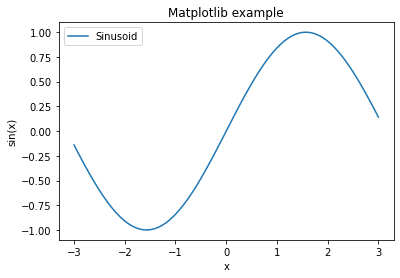

In [ ]:
from matplotlib import pyplot as plt

x_values = np.linspace(-3, 3, 100)

plt.figure()
plt.plot(x_values, np.sin(x_values), label="Sinusoid")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Matplotlib example")
plt.legend(loc="upper left")
plt.show()

We continue with a rudimentary scatter plot example. This example displays samples from the [iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) using the first two features. Colors indicate class membership (there are 3 classes).

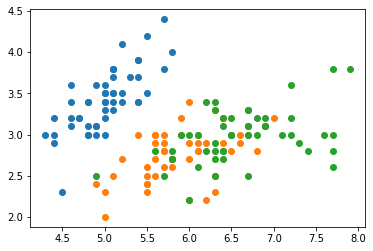

In [ ]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)

X_class0 = X[y == 0]
X_class1 = X[y == 1]
X_class2 = X[y == 2]

plt.figure()
plt.scatter(X_class0[:, 0], X_class0[:, 1], label="Class 0", color="C0")
plt.scatter(X_class1[:, 0], X_class1[:, 1], label="Class 1", color="C1")
plt.scatter(X_class2[:, 0], X_class2[:, 1], label="Class 2", color="C2")
plt.show()

We see that samples belonging to class 0 can be linearly separated from the rest using only the first two features.

## Exercises



**Exercise 1.** Plot the relu and the [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus) functions on the same graph.

What is the main difference between the two functions?

**Exercise 2.** Repeat the same scatter plot but using the [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) instead.

In [ ]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)

Are pixel values good features for classifying samples?

## Going further

*  Official [tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html)
